In [1]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
import tensorflow as tf

import pickle

## Create model for pendulum behaviour + generate data

In [6]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [7]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0.5
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [48]:
# Generate noise
noise_sd = 0.3
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [49]:
# Generate training dataset

# Adjusting the time range
t_max_new = 1.5  # Set the maximum time to 0.75 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Phisics Informed Neural Network (predict parameters)

In [6]:
# Define a custom sine activation function
def sin_activation(x):
    return tf.sin(x)

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.out = tf.keras.layers.Dense(2)  # Output: [theta1]
        # Define bm as a trainable parameter
        self.bm = tf.Variable(initial_value=0.1, trainable=True, dtype=tf.float32)
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta


In [38]:
# Define the loss function
def loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, l):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        tape1.watch(t_tensor)
        tape2.watch(t_tensor)
        
        theta_pred = pinn(t_tensor)
        theta1_pred = theta_pred[:, 0]
        theta2_pred = theta_pred[:, 1]

        # Use the single value of bm and beta_3
        bm = pinn.bm

        # Compute derivatives
        # Compute the first derivatives for each component
        dtheta1_dt_pred = tape1.gradient(theta1_pred, t_tensor)
        dtheta1_dt_pred = tf.squeeze(dtheta1_dt_pred)

        dtheta2_dt_pred = tape2.gradient(theta2_pred, t_tensor)
        dtheta2_dt_pred = tf.squeeze(dtheta2_dt_pred)

        # Data loss: Mean Squared Error between predicted and noisy data
        theta_pred = pinn(t_train_tensor)
        data_loss = tf.reduce_mean(tf.square(theta_pred[:, 0] - actual_theta_noisy_train_tensor[:, 0]))

        # Physics loss: Based on the differential equations
        g = 9.81
        dtheta1_dt_equation = theta2_pred # 1st equation
        dtheta2_dt_equation = -(bm) * dtheta1_dt_equation - (g / l) * tf.sin(theta1_pred) # 2nd equation
        
        physics_loss_1 = tf.reduce_mean(tf.square(dtheta1_dt_pred - dtheta1_dt_equation))
        physics_loss_2 = tf.reduce_mean(tf.square(dtheta2_dt_pred - dtheta2_dt_equation))

        total_loss = data_loss + 1*physics_loss_1 + 1*physics_loss_2
    return total_loss

Epoch 0, Loss: 63.63733673095703
Trained value of bm: 0.02923630177974701


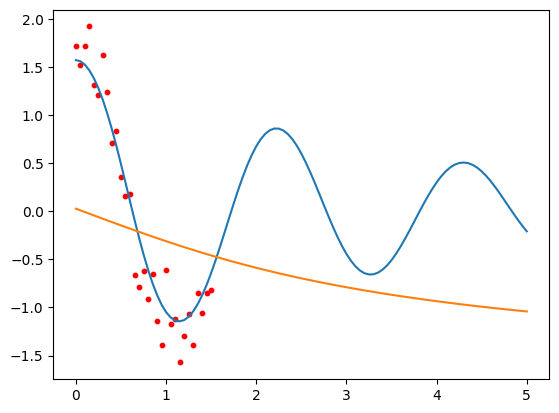

Epoch 1000, Loss: 1.2654367685317993
Trained value of bm: -0.03787059709429741
Epoch 2000, Loss: 1.2129889726638794
Trained value of bm: -0.27498316764831543
Epoch 3000, Loss: 0.6737200617790222
Trained value of bm: 0.017330193892121315
Epoch 4000, Loss: 0.18052080273628235
Trained value of bm: 1.3835268020629883
Epoch 5000, Loss: 0.13440312445163727
Trained value of bm: 1.260263204574585


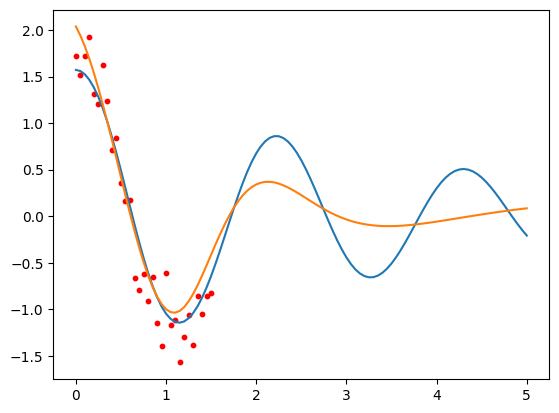

Epoch 6000, Loss: 0.2159816324710846
Trained value of bm: 1.0826151371002197
Epoch 7000, Loss: 0.09423822909593582
Trained value of bm: 0.9907310605049133
Epoch 8000, Loss: 0.08550551533699036
Trained value of bm: 0.94899982213974
Epoch 9000, Loss: 0.0788731575012207
Trained value of bm: 0.9010517001152039
Epoch 10000, Loss: 0.07161382585763931
Trained value of bm: 0.8456766605377197


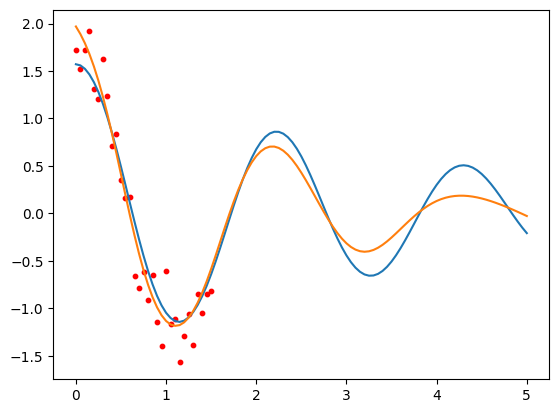

Epoch 11000, Loss: 0.08205096423625946
Trained value of bm: 0.7720054984092712
Epoch 12000, Loss: 0.07113061100244522
Trained value of bm: 0.7096045613288879
Epoch 13000, Loss: 0.0608021505177021
Trained value of bm: 0.6757725477218628
Epoch 14000, Loss: 0.06013691425323486
Trained value of bm: 0.6550259590148926
Epoch 15000, Loss: 0.05957121402025223
Trained value of bm: 0.6402900218963623


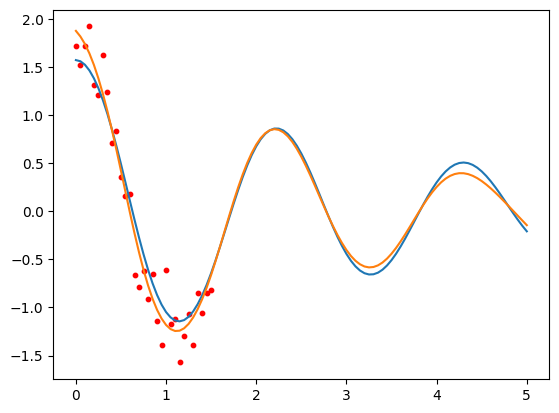

Epoch 16000, Loss: 0.05949896574020386
Trained value of bm: 0.628831684589386
Epoch 17000, Loss: 0.07152920961380005
Trained value of bm: 0.6156294345855713
Epoch 18000, Loss: 0.056862182915210724
Trained value of bm: 0.60310298204422
Epoch 19000, Loss: 0.058426328003406525
Trained value of bm: 0.5854834318161011
Epoch 20000, Loss: 0.0551704578101635
Trained value of bm: 0.5657615661621094


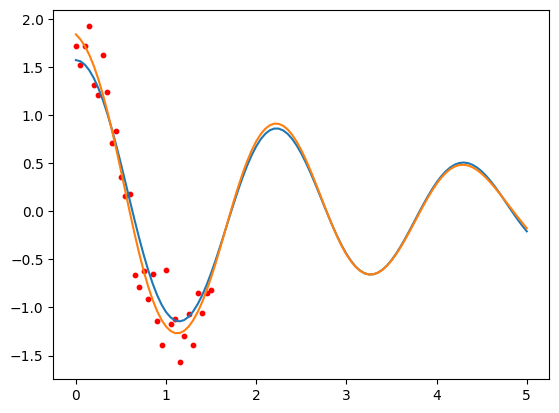

Epoch 21000, Loss: 0.05498567223548889
Trained value of bm: 0.5453850626945496
Epoch 22000, Loss: 0.054340582340955734
Trained value of bm: 0.5282799005508423
Epoch 23000, Loss: 0.056335676461458206
Trained value of bm: 0.5179473161697388
Epoch 24000, Loss: 0.0551748126745224
Trained value of bm: 0.5072165727615356
Epoch 25000, Loss: 0.05401049181818962
Trained value of bm: 0.501970112323761


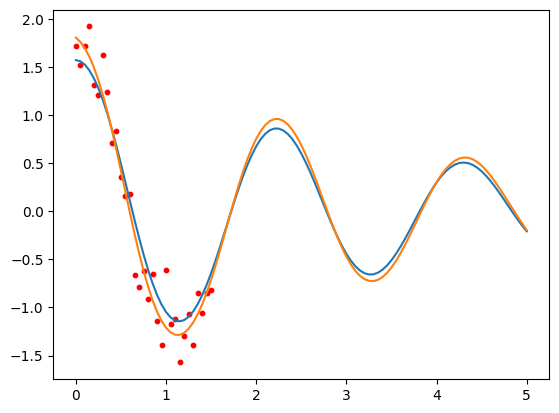

Epoch 26000, Loss: 0.05429484322667122
Trained value of bm: 0.498526930809021
Epoch 27000, Loss: 0.05414579063653946
Trained value of bm: 0.4977303147315979
Epoch 28000, Loss: 0.054990433156490326
Trained value of bm: 0.49481064081192017
Epoch 29000, Loss: 0.05385524407029152
Trained value of bm: 0.4961603581905365
Epoch 30000, Loss: 0.05473049357533455
Trained value of bm: 0.4957869052886963


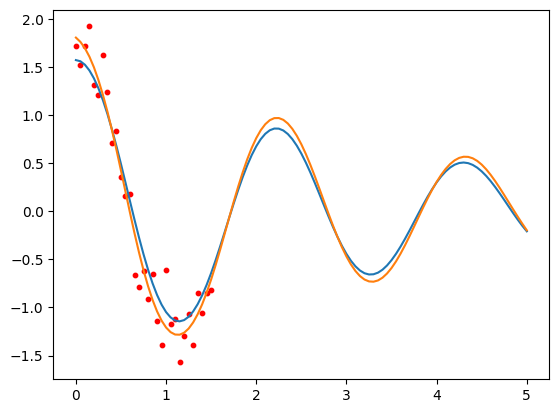

Epoch 31000, Loss: 0.05387147516012192
Trained value of bm: 0.4957117736339569
Epoch 32000, Loss: 0.0538589283823967
Trained value of bm: 0.4957692623138428
Epoch 33000, Loss: 0.05428992956876755
Trained value of bm: 0.49619415402412415
Epoch 34000, Loss: 0.0540211983025074
Trained value of bm: 0.495528906583786
Epoch 35000, Loss: 0.054967548698186874
Trained value of bm: 0.49743980169296265


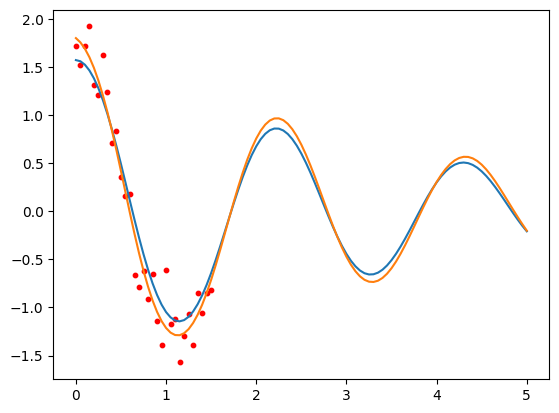

Epoch 36000, Loss: 0.05389394238591194
Trained value of bm: 0.49564802646636963
Epoch 37000, Loss: 0.05612132325768471
Trained value of bm: 0.49551764130592346
Epoch 38000, Loss: 0.05455019697546959
Trained value of bm: 0.49555912613868713
Epoch 39000, Loss: 0.05853366479277611
Trained value of bm: 0.4928315579891205
Epoch 40000, Loss: 0.05408069118857384
Trained value of bm: 0.49486032128334045


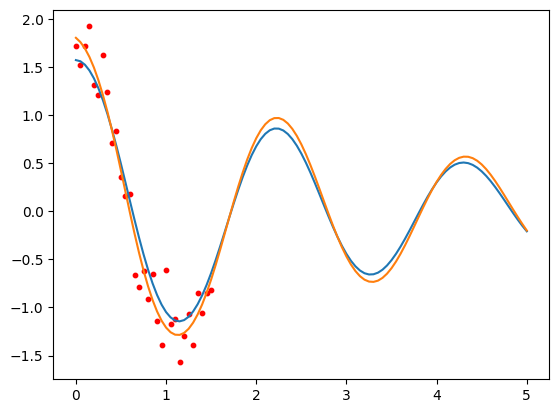

Epoch 41000, Loss: 0.053836945444345474
Trained value of bm: 0.4944608807563782
Epoch 42000, Loss: 0.053761500865221024
Trained value of bm: 0.49473074078559875
Epoch 43000, Loss: 0.0538782998919487
Trained value of bm: 0.49422216415405273
Epoch 44000, Loss: 0.05382540449500084
Trained value of bm: 0.4942563772201538
Epoch 45000, Loss: 0.05391206219792366
Trained value of bm: 0.4934387803077698


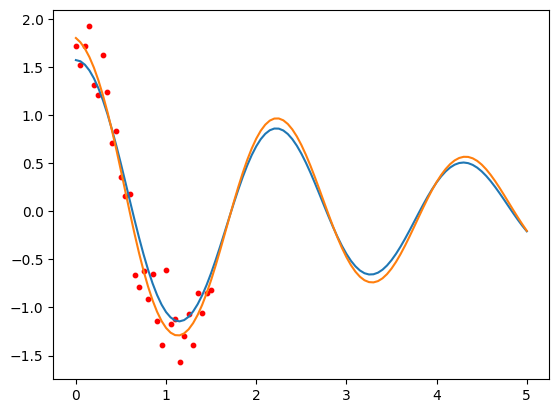

Epoch 46000, Loss: 0.05435267835855484
Trained value of bm: 0.49219709634780884
Epoch 47000, Loss: 0.05964573845267296
Trained value of bm: 0.48927250504493713
Epoch 48000, Loss: 0.05370688438415527
Trained value of bm: 0.4927142262458801
Epoch 49000, Loss: 0.053756702691316605
Trained value of bm: 0.4929201006889343
Epoch 50000, Loss: 0.05370040237903595
Trained value of bm: 0.4923885762691498


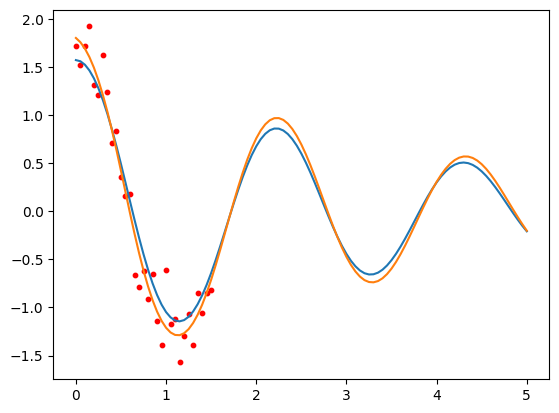

Epoch 51000, Loss: 0.05369801074266434
Trained value of bm: 0.49217772483825684
Epoch 52000, Loss: 0.05375136807560921
Trained value of bm: 0.49201783537864685
Epoch 53000, Loss: 0.053689222782850266
Trained value of bm: 0.4921215772628784
Epoch 54000, Loss: 0.0537160225212574
Trained value of bm: 0.4917372763156891
Epoch 55000, Loss: 0.053724609315395355
Trained value of bm: 0.4918662905693054


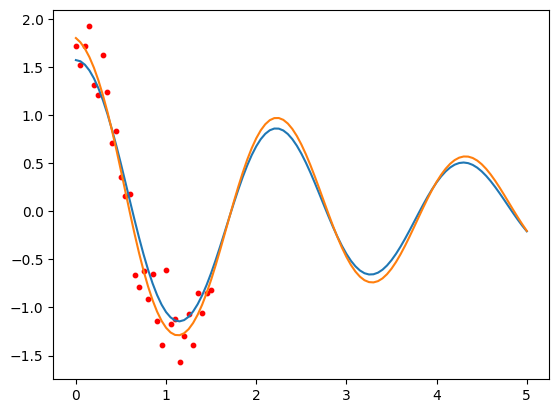

Epoch 56000, Loss: 0.05456971377134323
Trained value of bm: 0.4903388023376465
Epoch 57000, Loss: 0.053680431097745895
Trained value of bm: 0.4914836585521698
Epoch 58000, Loss: 0.054071422666311264
Trained value of bm: 0.4912601709365845
Epoch 59000, Loss: 0.05390508845448494
Trained value of bm: 0.4916498363018036
Epoch 60000, Loss: 0.053692493587732315
Trained value of bm: 0.49064141511917114


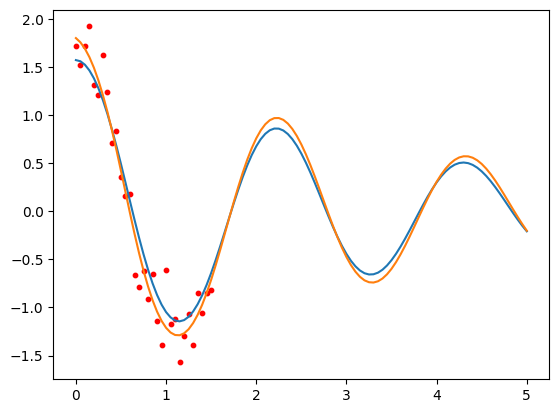

Epoch 61000, Loss: 0.054882947355508804
Trained value of bm: 0.4927656054496765
Epoch 62000, Loss: 0.053680893033742905
Trained value of bm: 0.49102601408958435
Epoch 63000, Loss: 0.05445579066872597
Trained value of bm: 0.48999789357185364
Epoch 64000, Loss: 0.053783513605594635
Trained value of bm: 0.49093133211135864
Epoch 65000, Loss: 0.053674135357141495
Trained value of bm: 0.4894229769706726


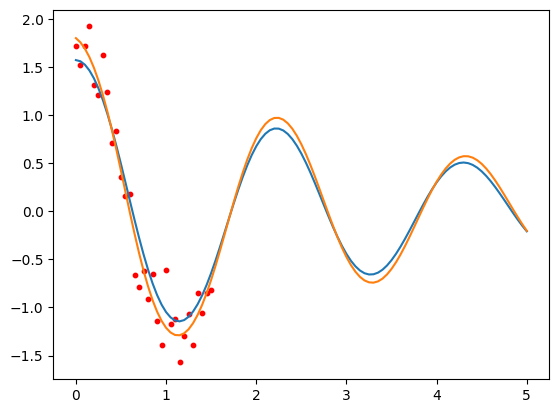

Epoch 66000, Loss: 0.05368901044130325
Trained value of bm: 0.4908447563648224
Epoch 67000, Loss: 0.05367489904165268
Trained value of bm: 0.4908059239387512
Epoch 68000, Loss: 0.05483516678214073
Trained value of bm: 0.491754949092865
Epoch 69000, Loss: 0.053865958005189896
Trained value of bm: 0.49042001366615295
Epoch 70000, Loss: 0.053698018193244934
Trained value of bm: 0.4907189905643463


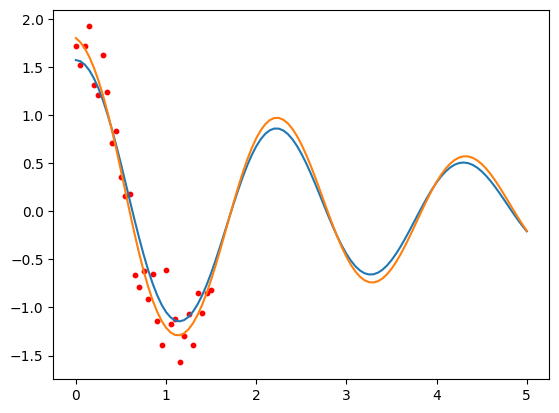

Epoch 71000, Loss: 0.0536855086684227
Trained value of bm: 0.49079686403274536
Epoch 72000, Loss: 0.05388646572828293
Trained value of bm: 0.49021634459495544
Epoch 73000, Loss: 0.054094281047582626
Trained value of bm: 0.4906211793422699
Epoch 74000, Loss: 0.0540570430457592
Trained value of bm: 0.49068623781204224
Epoch 75000, Loss: 0.053686805069446564
Trained value of bm: 0.4904027581214905


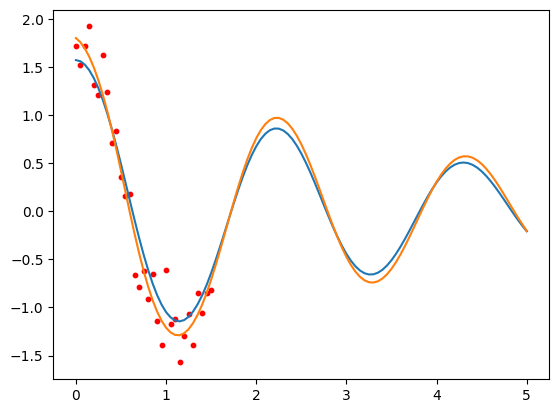

Epoch 76000, Loss: 0.05370355024933815
Trained value of bm: 0.4902064800262451
Epoch 77000, Loss: 0.05485694110393524
Trained value of bm: 0.4907735586166382
Epoch 78000, Loss: 0.05385196581482887
Trained value of bm: 0.4909763038158417
Epoch 79000, Loss: 0.053672343492507935
Trained value of bm: 0.48975861072540283
Epoch 80000, Loss: 0.05370767042040825
Trained value of bm: 0.48995789885520935


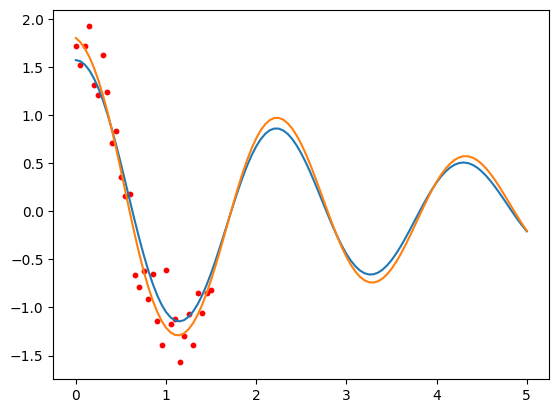

Epoch 81000, Loss: 0.0560753270983696
Trained value of bm: 0.49017417430877686
Epoch 82000, Loss: 0.05369877070188522
Trained value of bm: 0.4906045198440552
Epoch 83000, Loss: 0.05422469973564148
Trained value of bm: 0.49019646644592285
Epoch 84000, Loss: 0.05402464047074318
Trained value of bm: 0.4908652603626251
Epoch 85000, Loss: 0.05384759604930878
Trained value of bm: 0.49098026752471924


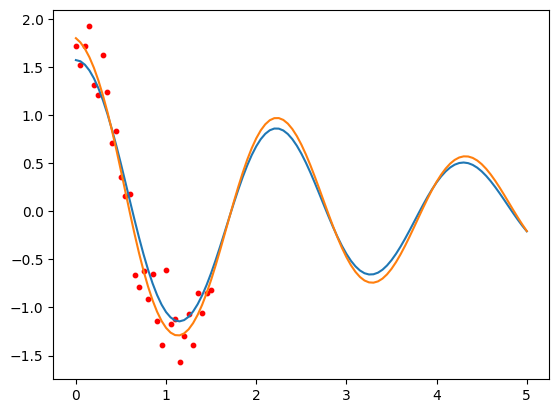

Epoch 86000, Loss: 0.05367882177233696
Trained value of bm: 0.4901604652404785
Epoch 87000, Loss: 0.053713358938694
Trained value of bm: 0.4902976155281067
Epoch 88000, Loss: 0.05487355962395668
Trained value of bm: 0.49174487590789795
Epoch 89000, Loss: 0.05366814509034157
Trained value of bm: 0.4894794523715973
Epoch 90000, Loss: 0.05582432821393013
Trained value of bm: 0.4903917908668518


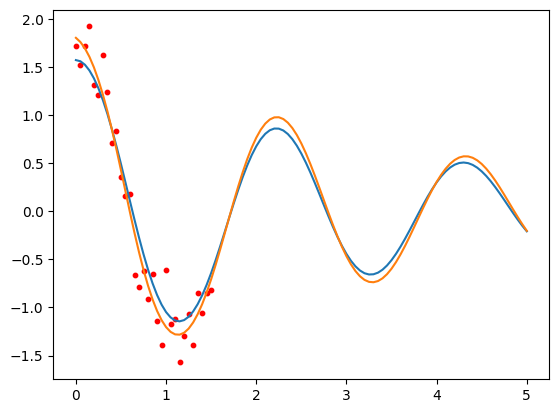

Epoch 91000, Loss: 0.05490599945187569
Trained value of bm: 0.4898386299610138
Epoch 92000, Loss: 0.05373188853263855
Trained value of bm: 0.4901302754878998
Epoch 93000, Loss: 0.05366218835115433
Trained value of bm: 0.49030518531799316
Epoch 94000, Loss: 0.05424854904413223
Trained value of bm: 0.48900583386421204
Epoch 95000, Loss: 0.053660161793231964
Trained value of bm: 0.4901360869407654


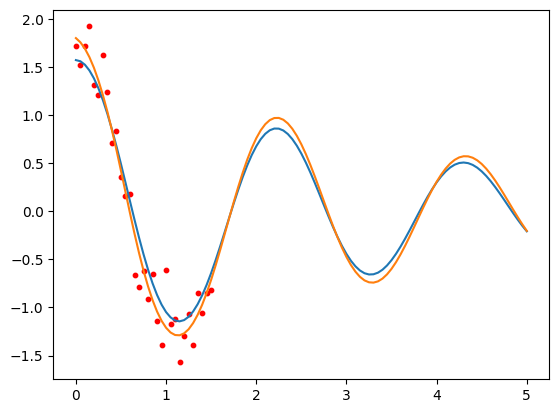

Epoch 96000, Loss: 0.053875043988227844
Trained value of bm: 0.4903148412704468
Epoch 97000, Loss: 0.05365961417555809
Trained value of bm: 0.4900156855583191
Epoch 98000, Loss: 0.05369623377919197
Trained value of bm: 0.48999789357185364
Epoch 99000, Loss: 0.05394240468740463
Trained value of bm: 0.4891737699508667
Epoch 100000, Loss: 0.05365884676575661
Trained value of bm: 0.4892522692680359


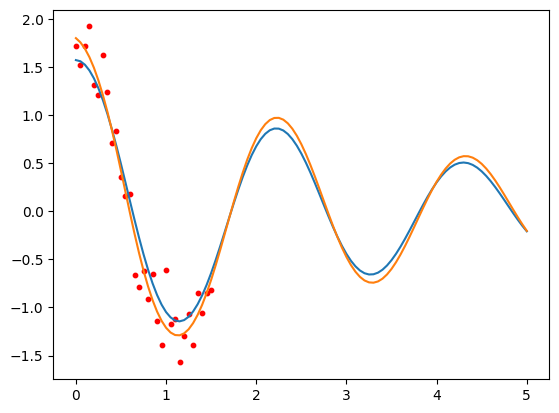

Epoch 101000, Loss: 0.059790994971990585
Trained value of bm: 0.48540762066841125
Epoch 102000, Loss: 0.053663384169340134
Trained value of bm: 0.4901121258735657
Epoch 103000, Loss: 0.05477053299546242
Trained value of bm: 0.4911246597766876
Epoch 104000, Loss: 0.05365922674536705
Trained value of bm: 0.49028152227401733
Epoch 105000, Loss: 0.0546116903424263
Trained value of bm: 0.4901345670223236


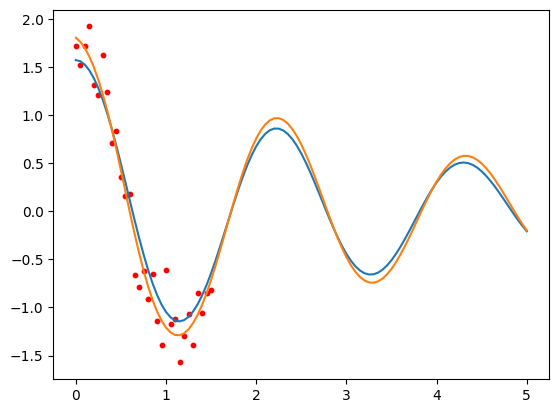

Epoch 106000, Loss: 0.053665850311517715
Trained value of bm: 0.4901851713657379
Epoch 107000, Loss: 0.05365878343582153
Trained value of bm: 0.4893343448638916
Epoch 108000, Loss: 0.05365671589970589
Trained value of bm: 0.48936182260513306
Epoch 109000, Loss: 0.05365655571222305
Trained value of bm: 0.4900617301464081
Epoch 110000, Loss: 0.053687240928411484
Trained value of bm: 0.4901482164859772


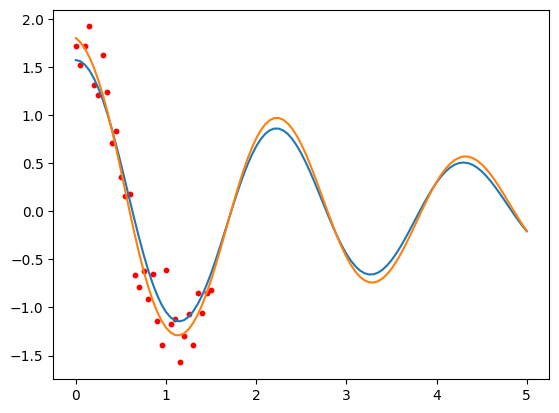

Epoch 111000, Loss: 0.05366217717528343
Trained value of bm: 0.490369975566864
Epoch 112000, Loss: 0.053663093596696854
Trained value of bm: 0.4900999069213867
Epoch 113000, Loss: 0.05371341481804848
Trained value of bm: 0.4904153048992157
Epoch 114000, Loss: 0.05412203446030617
Trained value of bm: 0.4909432530403137
Epoch 115000, Loss: 0.05370680242776871
Trained value of bm: 0.49021485447883606


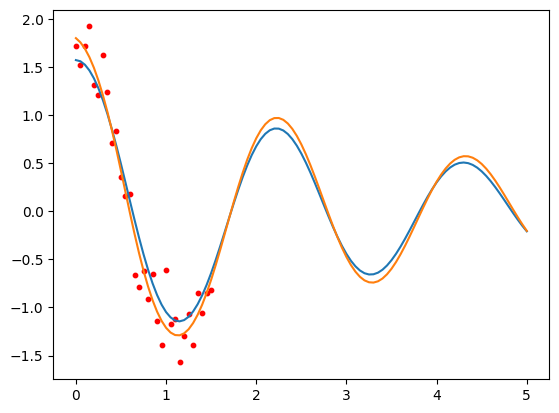

Epoch 116000, Loss: 0.05365503579378128
Trained value of bm: 0.4887533485889435
Epoch 117000, Loss: 0.05365480110049248
Trained value of bm: 0.489920049905777
Epoch 118000, Loss: 0.053692907094955444
Trained value of bm: 0.49023327231407166
Epoch 119000, Loss: 0.054541848599910736
Trained value of bm: 0.4905109405517578
Epoch 120000, Loss: 0.05401202663779259
Trained value of bm: 0.49089741706848145


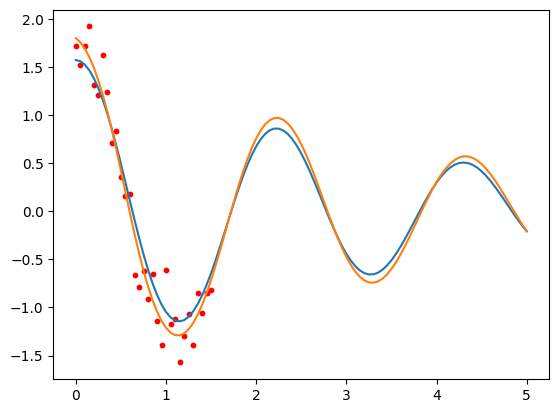

Epoch 121000, Loss: 0.053699739277362823
Trained value of bm: 0.48961591720581055
Epoch 122000, Loss: 0.053654301911592484
Trained value of bm: 0.48948702216148376
Epoch 123000, Loss: 0.05365465208888054
Trained value of bm: 0.4898524284362793
Epoch 124000, Loss: 0.05463037267327309
Trained value of bm: 0.4885406792163849
Epoch 125000, Loss: 0.05368584394454956
Trained value of bm: 0.49005481600761414


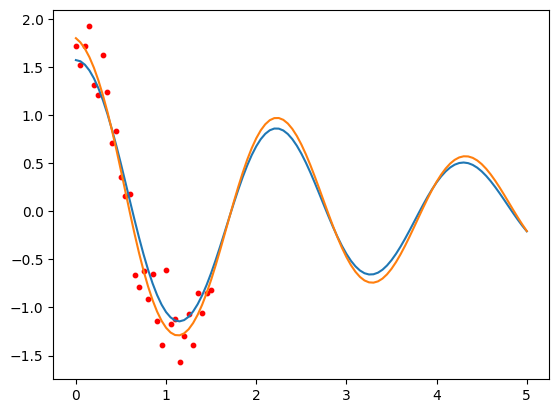

Epoch 126000, Loss: 0.05396591126918793
Trained value of bm: 0.4893861413002014
Epoch 127000, Loss: 0.05369022488594055
Trained value of bm: 0.490047425031662
Epoch 128000, Loss: 0.05372937396168709
Trained value of bm: 0.489969938993454
Epoch 129000, Loss: 0.053653325885534286
Trained value of bm: 0.48946550488471985
Epoch 130000, Loss: 0.0549822635948658
Trained value of bm: 0.49119505286216736


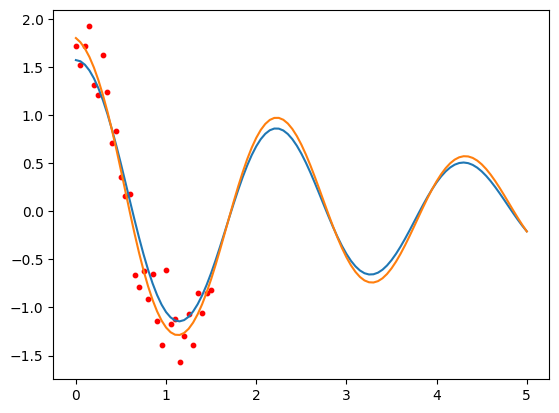

Epoch 131000, Loss: 0.0536651685833931
Trained value of bm: 0.4897691607475281
Epoch 132000, Loss: 0.05668186768889427
Trained value of bm: 0.4872108995914459
Epoch 133000, Loss: 0.053769346326589584
Trained value of bm: 0.4896351099014282
Epoch 134000, Loss: 0.053659357130527496
Trained value of bm: 0.4898967742919922
Epoch 135000, Loss: 0.053653132170438766
Trained value of bm: 0.4892599284648895


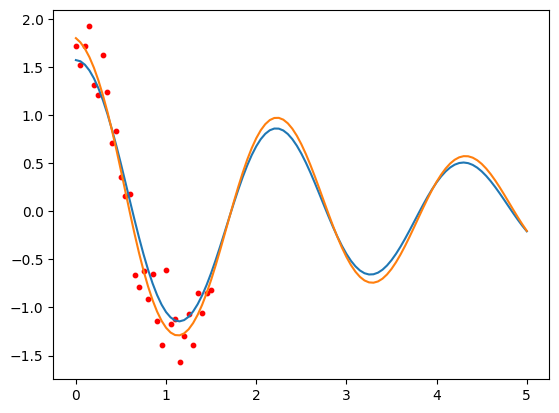

Epoch 136000, Loss: 0.05369371920824051
Trained value of bm: 0.48956283926963806
Epoch 137000, Loss: 0.053653184324502945
Trained value of bm: 0.48992079496383667
Epoch 138000, Loss: 0.05372364819049835
Trained value of bm: 0.4897218942642212
Epoch 139000, Loss: 0.0536593496799469
Trained value of bm: 0.4899522066116333
Epoch 140000, Loss: 0.05366251617670059
Trained value of bm: 0.49000898003578186


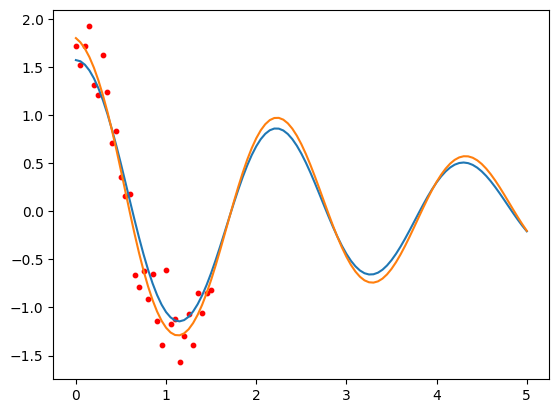

Epoch 141000, Loss: 0.05473697558045387
Trained value of bm: 0.49155759811401367
Epoch 142000, Loss: 0.05365273356437683
Trained value of bm: 0.4894733428955078
Epoch 143000, Loss: 0.0537356436252594
Trained value of bm: 0.4895005524158478
Epoch 144000, Loss: 0.05367617309093475
Trained value of bm: 0.48984867334365845
Epoch 145000, Loss: 0.05369047820568085
Trained value of bm: 0.49028441309928894


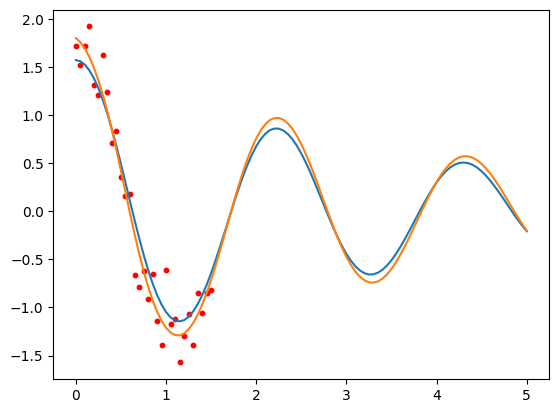

Epoch 146000, Loss: 0.054031964391469955
Trained value of bm: 0.4896703064441681
Epoch 147000, Loss: 0.05377236753702164
Trained value of bm: 0.49032139778137207
Epoch 148000, Loss: 0.053657498210668564
Trained value of bm: 0.4900866448879242
Epoch 149000, Loss: 0.05370780825614929
Trained value of bm: 0.490212082862854
Epoch 150000, Loss: 0.05365266650915146
Trained value of bm: 0.48955124616622925


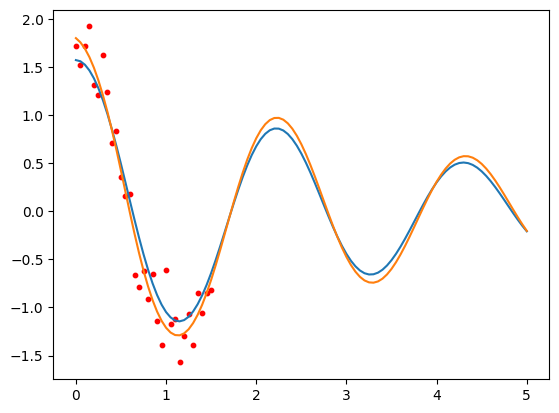

Epoch 151000, Loss: 0.05369632691144943
Trained value of bm: 0.4891846477985382
Epoch 152000, Loss: 0.05369112640619278
Trained value of bm: 0.4900363087654114
Epoch 153000, Loss: 0.05366696044802666
Trained value of bm: 0.4905168414115906
Epoch 154000, Loss: 0.053675342351198196
Trained value of bm: 0.49009591341018677
Epoch 155000, Loss: 0.053655002266168594
Trained value of bm: 0.4899210035800934


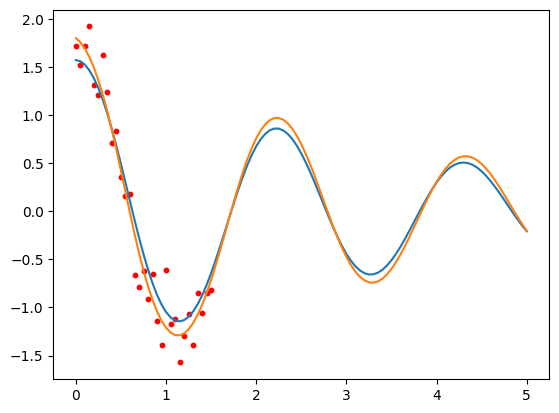

Epoch 156000, Loss: 0.053652599453926086
Trained value of bm: 0.48962557315826416
Epoch 157000, Loss: 0.054353129118680954
Trained value of bm: 0.4898184835910797
Epoch 158000, Loss: 0.05366900935769081
Trained value of bm: 0.48839494585990906
Epoch 159000, Loss: 0.055049650371074677
Trained value of bm: 0.49131831526756287
Epoch 160000, Loss: 0.05605129152536392
Trained value of bm: 0.49222496151924133


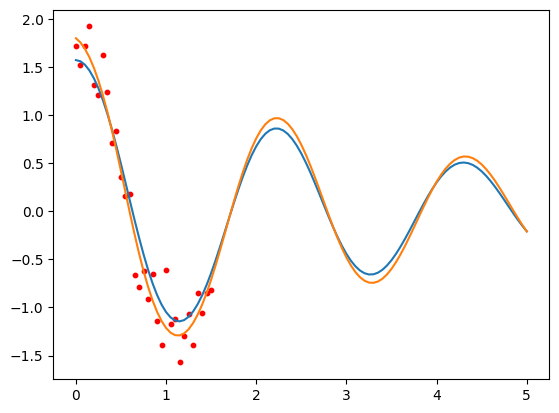

Epoch 161000, Loss: 0.053652387112379074
Trained value of bm: 0.4902563691139221
Epoch 162000, Loss: 0.05366537347435951
Trained value of bm: 0.489929735660553
Epoch 163000, Loss: 0.055885590612888336
Trained value of bm: 0.48828843235969543
Epoch 164000, Loss: 0.05367274954915047
Trained value of bm: 0.4901842772960663
Epoch 165000, Loss: 0.05367099493741989
Trained value of bm: 0.4897947311401367


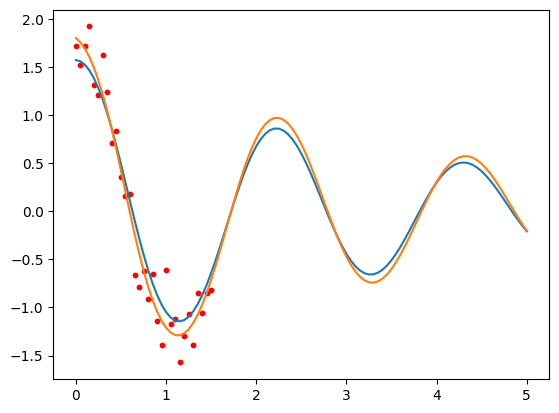

Epoch 166000, Loss: 0.05365215241909027
Trained value of bm: 0.4880297780036926
Epoch 167000, Loss: 0.053651805967092514
Trained value of bm: 0.48934733867645264
Epoch 168000, Loss: 0.05369569733738899
Trained value of bm: 0.4901996850967407
Epoch 169000, Loss: 0.05365591496229172
Trained value of bm: 0.4900457561016083
Epoch 170000, Loss: 0.05414436757564545
Trained value of bm: 0.4906347095966339


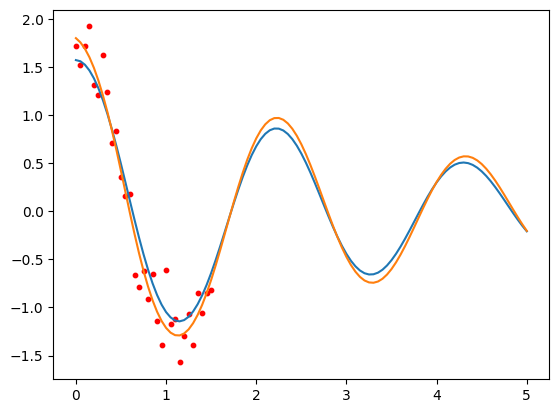

Epoch 171000, Loss: 0.05437181517481804
Trained value of bm: 0.4886418581008911
Epoch 172000, Loss: 0.053837232291698456
Trained value of bm: 0.48922228813171387
Epoch 173000, Loss: 0.053664833307266235
Trained value of bm: 0.4845028221607208
Epoch 174000, Loss: 0.05365261435508728
Trained value of bm: 0.48779258131980896
Epoch 175000, Loss: 0.05365212634205818
Trained value of bm: 0.4895131587982178


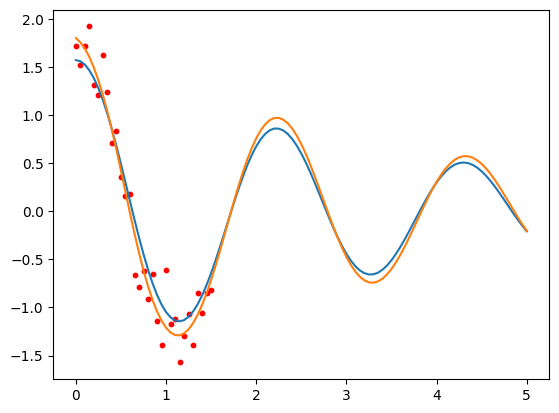

Epoch 176000, Loss: 0.0536862313747406
Trained value of bm: 0.4901360273361206
Epoch 177000, Loss: 0.05374404788017273
Trained value of bm: 0.4899030923843384
Epoch 178000, Loss: 0.05371139943599701
Trained value of bm: 0.48990917205810547
Epoch 179000, Loss: 0.053654417395591736
Trained value of bm: 0.48995187878608704
Epoch 180000, Loss: 0.05391889810562134
Trained value of bm: 0.4906614422798157


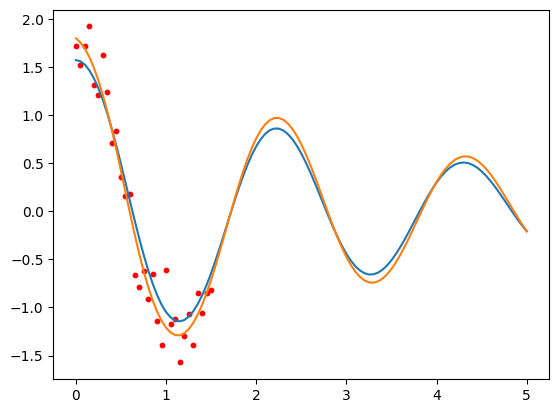

Epoch 181000, Loss: 0.05365341156721115
Trained value of bm: 0.4927923381328583
Epoch 182000, Loss: 0.05366520583629608
Trained value of bm: 0.4894084632396698
Epoch 183000, Loss: 0.05369522422552109
Trained value of bm: 0.4898023009300232
Epoch 184000, Loss: 0.054027386009693146
Trained value of bm: 0.48963579535484314
Epoch 185000, Loss: 0.05435894802212715
Trained value of bm: 0.4908120632171631


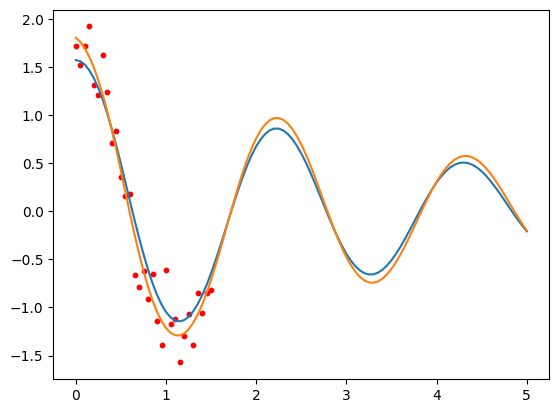

Epoch 186000, Loss: 0.053745582699775696
Trained value of bm: 0.48960214853286743
Epoch 187000, Loss: 0.054057516157627106
Trained value of bm: 0.48991766571998596
Epoch 188000, Loss: 0.05365185812115669
Trained value of bm: 0.4898023307323456
Epoch 189000, Loss: 0.05365162342786789
Trained value of bm: 0.489693284034729
Epoch 190000, Loss: 0.053748585283756256
Trained value of bm: 0.4901413321495056


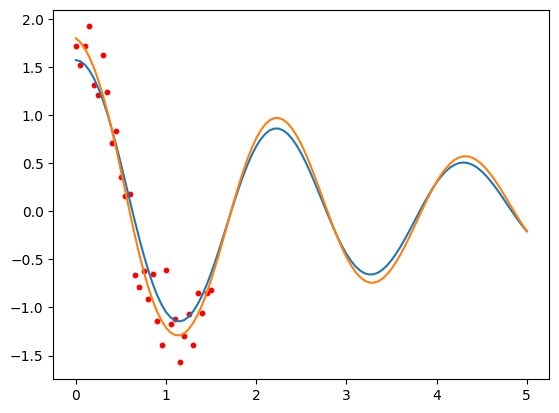

Epoch 191000, Loss: 0.05452302470803261
Trained value of bm: 0.49015095829963684
Epoch 192000, Loss: 0.05365823954343796
Trained value of bm: 0.48984605073928833
Epoch 193000, Loss: 0.05365554615855217
Trained value of bm: 0.48789775371551514
Epoch 194000, Loss: 0.053651705384254456
Trained value of bm: 0.48916494846343994
Epoch 195000, Loss: 0.053724709898233414
Trained value of bm: 0.48941099643707275


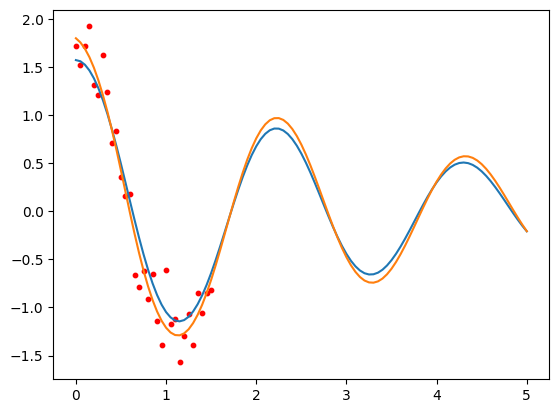

Epoch 196000, Loss: 0.05365976691246033
Trained value of bm: 0.4896552264690399
Epoch 197000, Loss: 0.0536581426858902
Trained value of bm: 0.49005410075187683
Epoch 198000, Loss: 0.053688012063503265
Trained value of bm: 0.4899703860282898
Epoch 199000, Loss: 0.05367232859134674
Trained value of bm: 0.49005091190338135


In [50]:
# Initialize the neural network
pinn = PINN()

# Convert training data to tensorflow tensors
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
t_train_tensor = tf.reshape(t_train_tensor, (-1, 1))

t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))

actual_theta_noisy_train_tensor = tf.convert_to_tensor(actual_theta_noisy_train, dtype=tf.float32)

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Initialize a list to store MSE values
loss_values = []
bm_values = []
beta_3_values = []

# Training loop
num_epochs = 200000
freq_store_values = 1000
freq_plot = 5000

for epoch in range(num_epochs):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss = loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, actual_params[1])
    grads = tape1.gradient(loss, pinn.trainable_variables)
    bm_gradients = tape2.gradient(loss, pinn.bm)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    pinn.bm.assign_sub(0.03 * bm_gradients)  # Adjust the learning rate as needed for bm
    
    if epoch % freq_store_values == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')
        loss_values.append(loss.numpy())
        print(f'Trained value of bm: {pinn.bm.numpy()}')
        bm_values.append(pinn.bm.numpy())

    if epoch % freq_plot == 0:
        theta_pred = pinn(t_tensor).numpy()
        plt.plot(t, actual_theta[:, 0], label='Actual θ1')
        plt.plot(t, theta_pred[:, 0], label='Predicted θ1')
        plt.scatter(t_train, actual_theta_noisy_train[:, 0], color='red', label='Noisy θ1', s=10)
        plt.show()


# After training, the model should be able to predict theta values that adhere to the differential equations

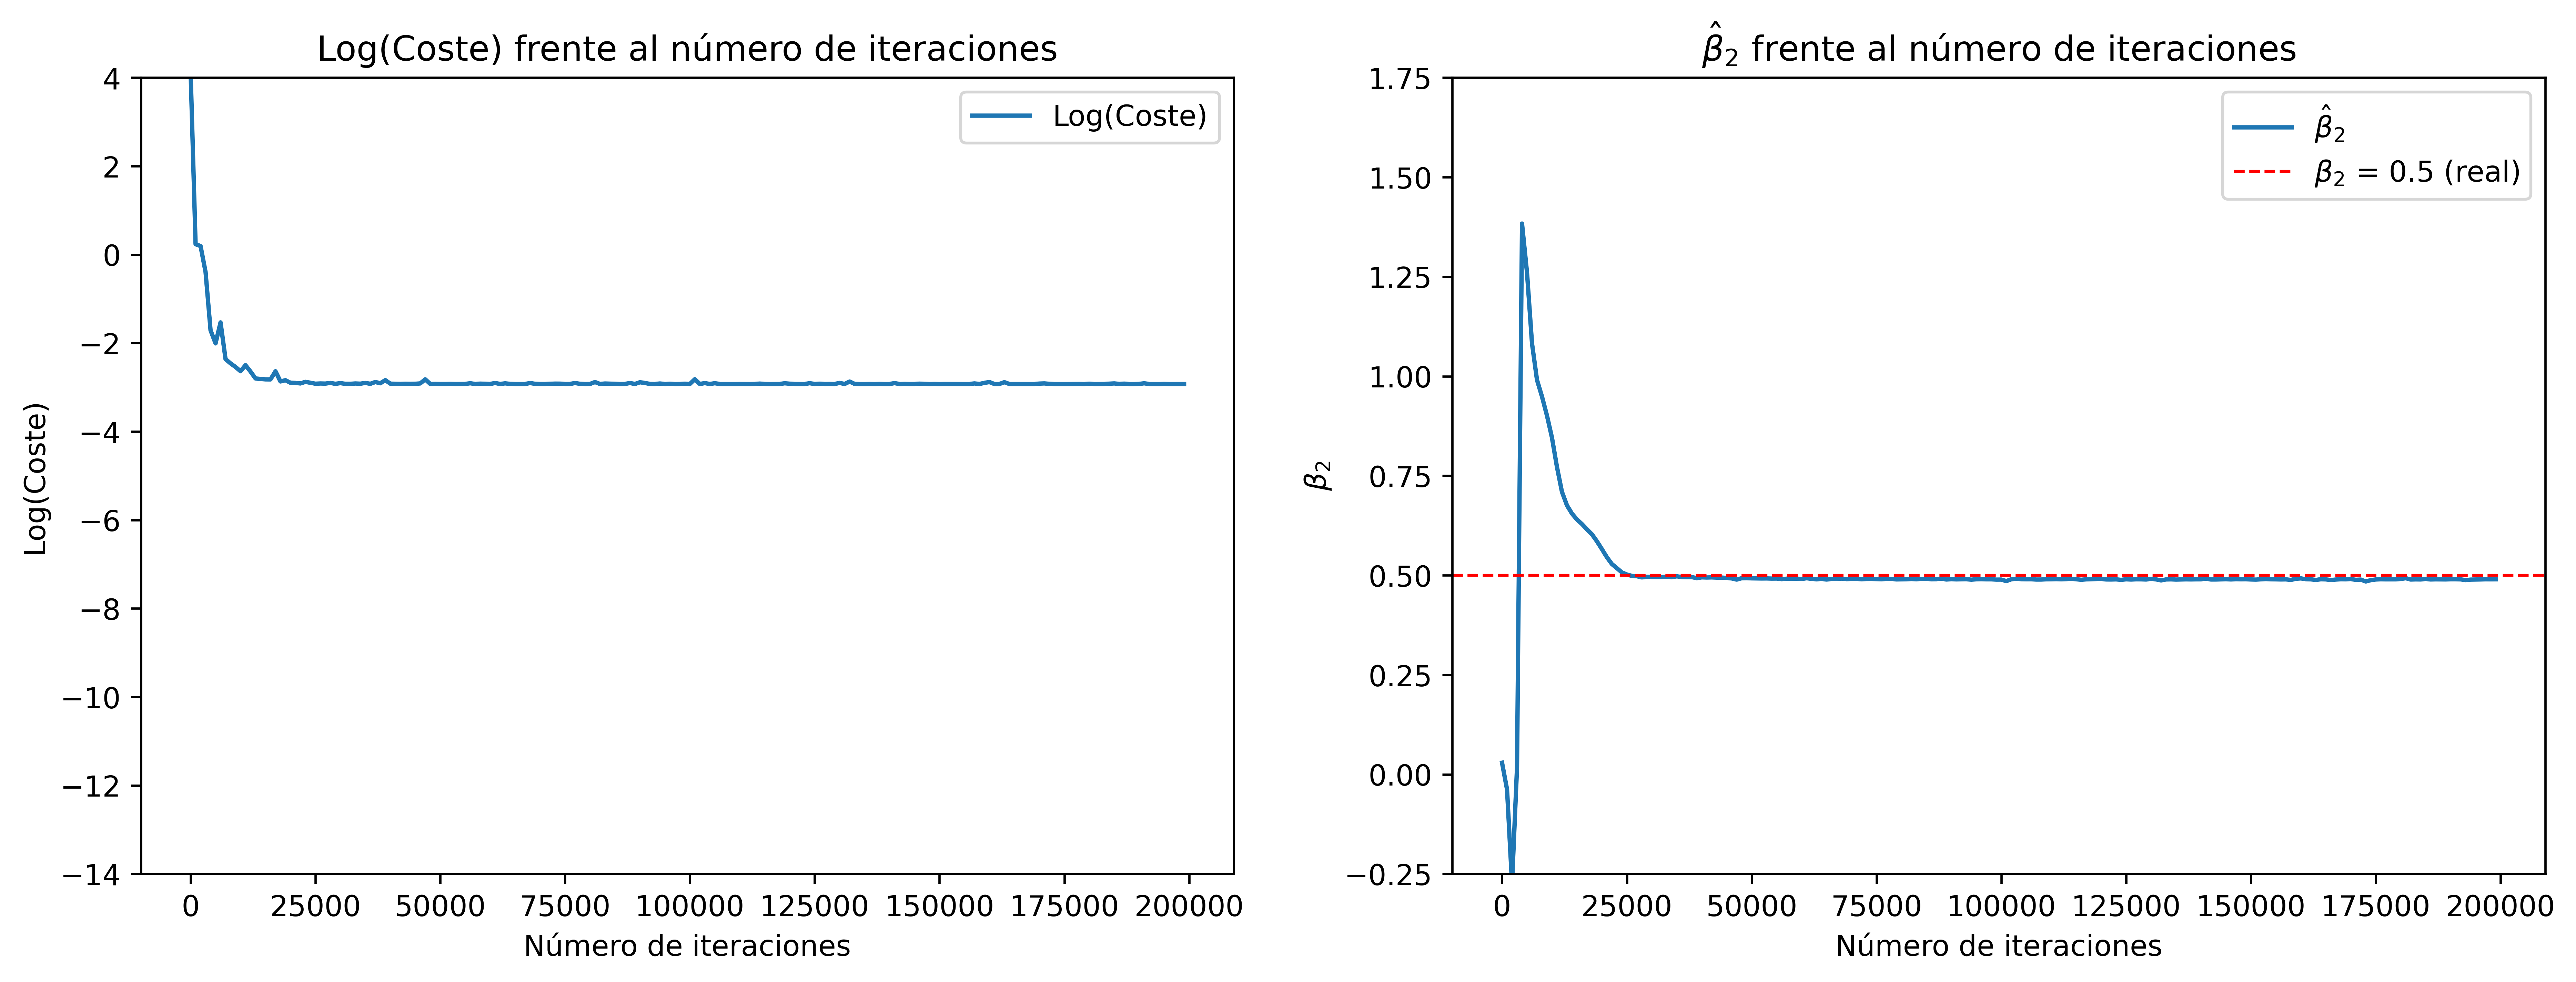

In [51]:
# Plot the results
plt.figure(figsize=(15, 5), dpi=600)

# Plot the MSE values
plt.subplot(1, 2, 1)
plt.plot(range(0, num_epochs, freq_store_values), np.log(loss_values), label='Log(Coste)')
plt.ylim(-14, 4)
plt.xlabel('Número de iteraciones')
plt.ylabel('Log(Coste)')
plt.title('Log(Coste) frente al número de iteraciones')
plt.legend()

# Plot the MSE values
plt.subplot(1, 2, 2)
plt.plot(range(0, num_epochs, freq_store_values), bm_values, label=r'$\hat{\beta}_2$')
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label=r'$\beta_2$ = 0.5 (real)')
plt.ylim(-0.25, 1.75)
plt.xlabel('Número de iteraciones')
plt.ylabel(r'$\beta_2$')
plt.title(r'$\hat{\beta}_2$ frente al número de iteraciones')
plt.legend()

plt.show()

In [52]:
with open(r'estimation_pickles/discovery_loss_values_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(loss_values, fp)

with open(r'estimation_pickles/discovery_bm_values_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(bm_values, fp)

with open(r'estimation_pickles/discovery_pinn_pred_00_000_150s_noise30.pkl', 'wb') as fp:
    pickle.dump(pinn(t_tensor).numpy(), fp)

In [21]:
with open(r'estimation_pickles/discovery_loss_values_00_000_150s_noise00.pkl', 'rb') as fp:
    loss_values = pickle.load(fp)

with open(r'estimation_pickles/discovery_bm_values_00_000_150s_noise00.pkl', 'rb') as fp:
    bm_values = pickle.load(fp)

with open(r'estimation_pickles/discovery_pinn_pred_00_000_150s_noise00.pkl', 'rb') as fp:
    pinn_pred = pickle.load(fp)

In [21]:
bm_values[-1]

0.49782616

In [2]:
beta_2_pinn = []
noises = ["00", "05", "10", "15", "20", "25", "30"]

for noise in noises:
    with open(f'estimation_pickles/discovery_bm_values_00_000_150s_noise{noise}.pkl', 'rb') as fp:
        beta_2_pinn_noise = pickle.load(fp)
        beta_2_pinn.append(beta_2_pinn_noise[-1])

beta_2_pinn

[0.50084984,
 0.49782616,
 0.49338728,
 0.48989394,
 0.49157667,
 0.4903154,
 0.4900509]

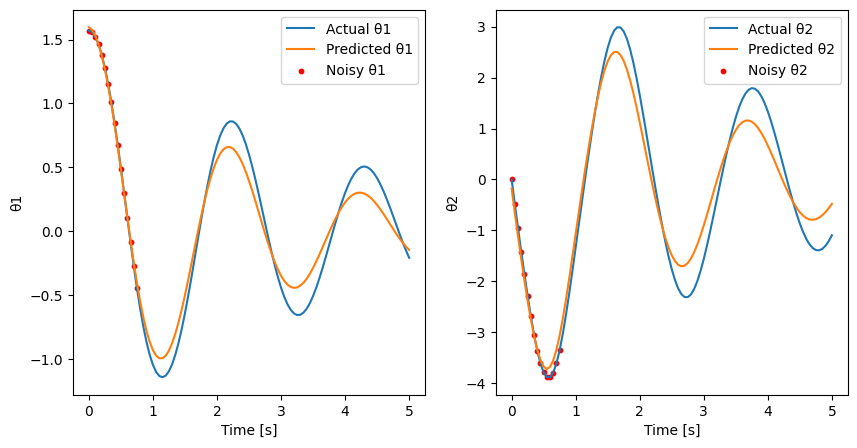

In [22]:
# Predict using the trained model
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))
theta_pred = pinn(t_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, actual_theta[:, 0], label='Actual θ1')
plt.plot(t, theta_pred[:, 0], label='Predicted θ1')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], color='red', label='Noisy θ1', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('θ1')

plt.subplot(1, 2, 2)
plt.plot(t, actual_theta[:, 1], label='Actual θ2')
plt.plot(t, theta_pred[:, 1], label='Predicted θ2')
plt.scatter(t_train, actual_theta_noisy_train[:, 1], color='red', label='Noisy θ2', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('θ2')

plt.show()

## Physics Informed Machine Learning

In [4]:
# Model with bm only
def model_discovery(theta, t, bm):
    g = 9.81
    l = 1
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt

# Loss function
def loss_function(bm, theta_0, t, actual_theta):
    predicted_theta = odeint(model_discovery, theta_0, t, args=(bm,))
    return np.mean((predicted_theta[:,0] - actual_theta[:,0]) ** 2)

# Gradient function
def gradient(bm, theta_0, t, actual_theta):
    eps = 1e-5
    bm_plus_eps = bm + eps
    bm_minus_eps = bm - eps
    grad = (loss_function(bm_plus_eps, theta_0, t, actual_theta) - 
            loss_function(bm_minus_eps, theta_0, t, actual_theta)) / (2 * eps)
    return grad

# Gradient descent function
def gradient_descent(theta_0, t, actual_theta, initial_bm, learning_rate=0.01, max_iters=500000, tol=1e-10):
    bm = initial_bm
    for i in range(max_iters):
        grad = gradient(bm, theta_0, t, actual_theta)
        bm -= learning_rate * grad
        if abs(grad) < tol:
            print(f"Converged after {i+1} iterations.")
            break
    return bm

In [62]:
# Initial parameter for gradient descent
initial_bm = 0.3

# Run gradient descent
estimated_bm = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_bm)
print("Estimated bm:", estimated_bm)

# Function to simulate the system with estimated bm
def simulate_system(theta_0, t, estimated_bm):
    estimated_theta = odeint(model_discovery, theta_0, t, args=(estimated_bm,))
    return estimated_theta

# Simulate the system with estimated bm
estimated_theta = simulate_system(actual_theta_0, t, estimated_bm)

# Calculate mean squared difference
squared_diff = np.square(actual_theta[:, 0] - estimated_theta[:, 0])
mean_squared_diff = np.mean(squared_diff)
print("Mean Squared Difference:", mean_squared_diff)

Converged after 2932 iterations.
Estimated bm: 0.2906455693200609
Mean Squared Difference: 0.03302143573686071


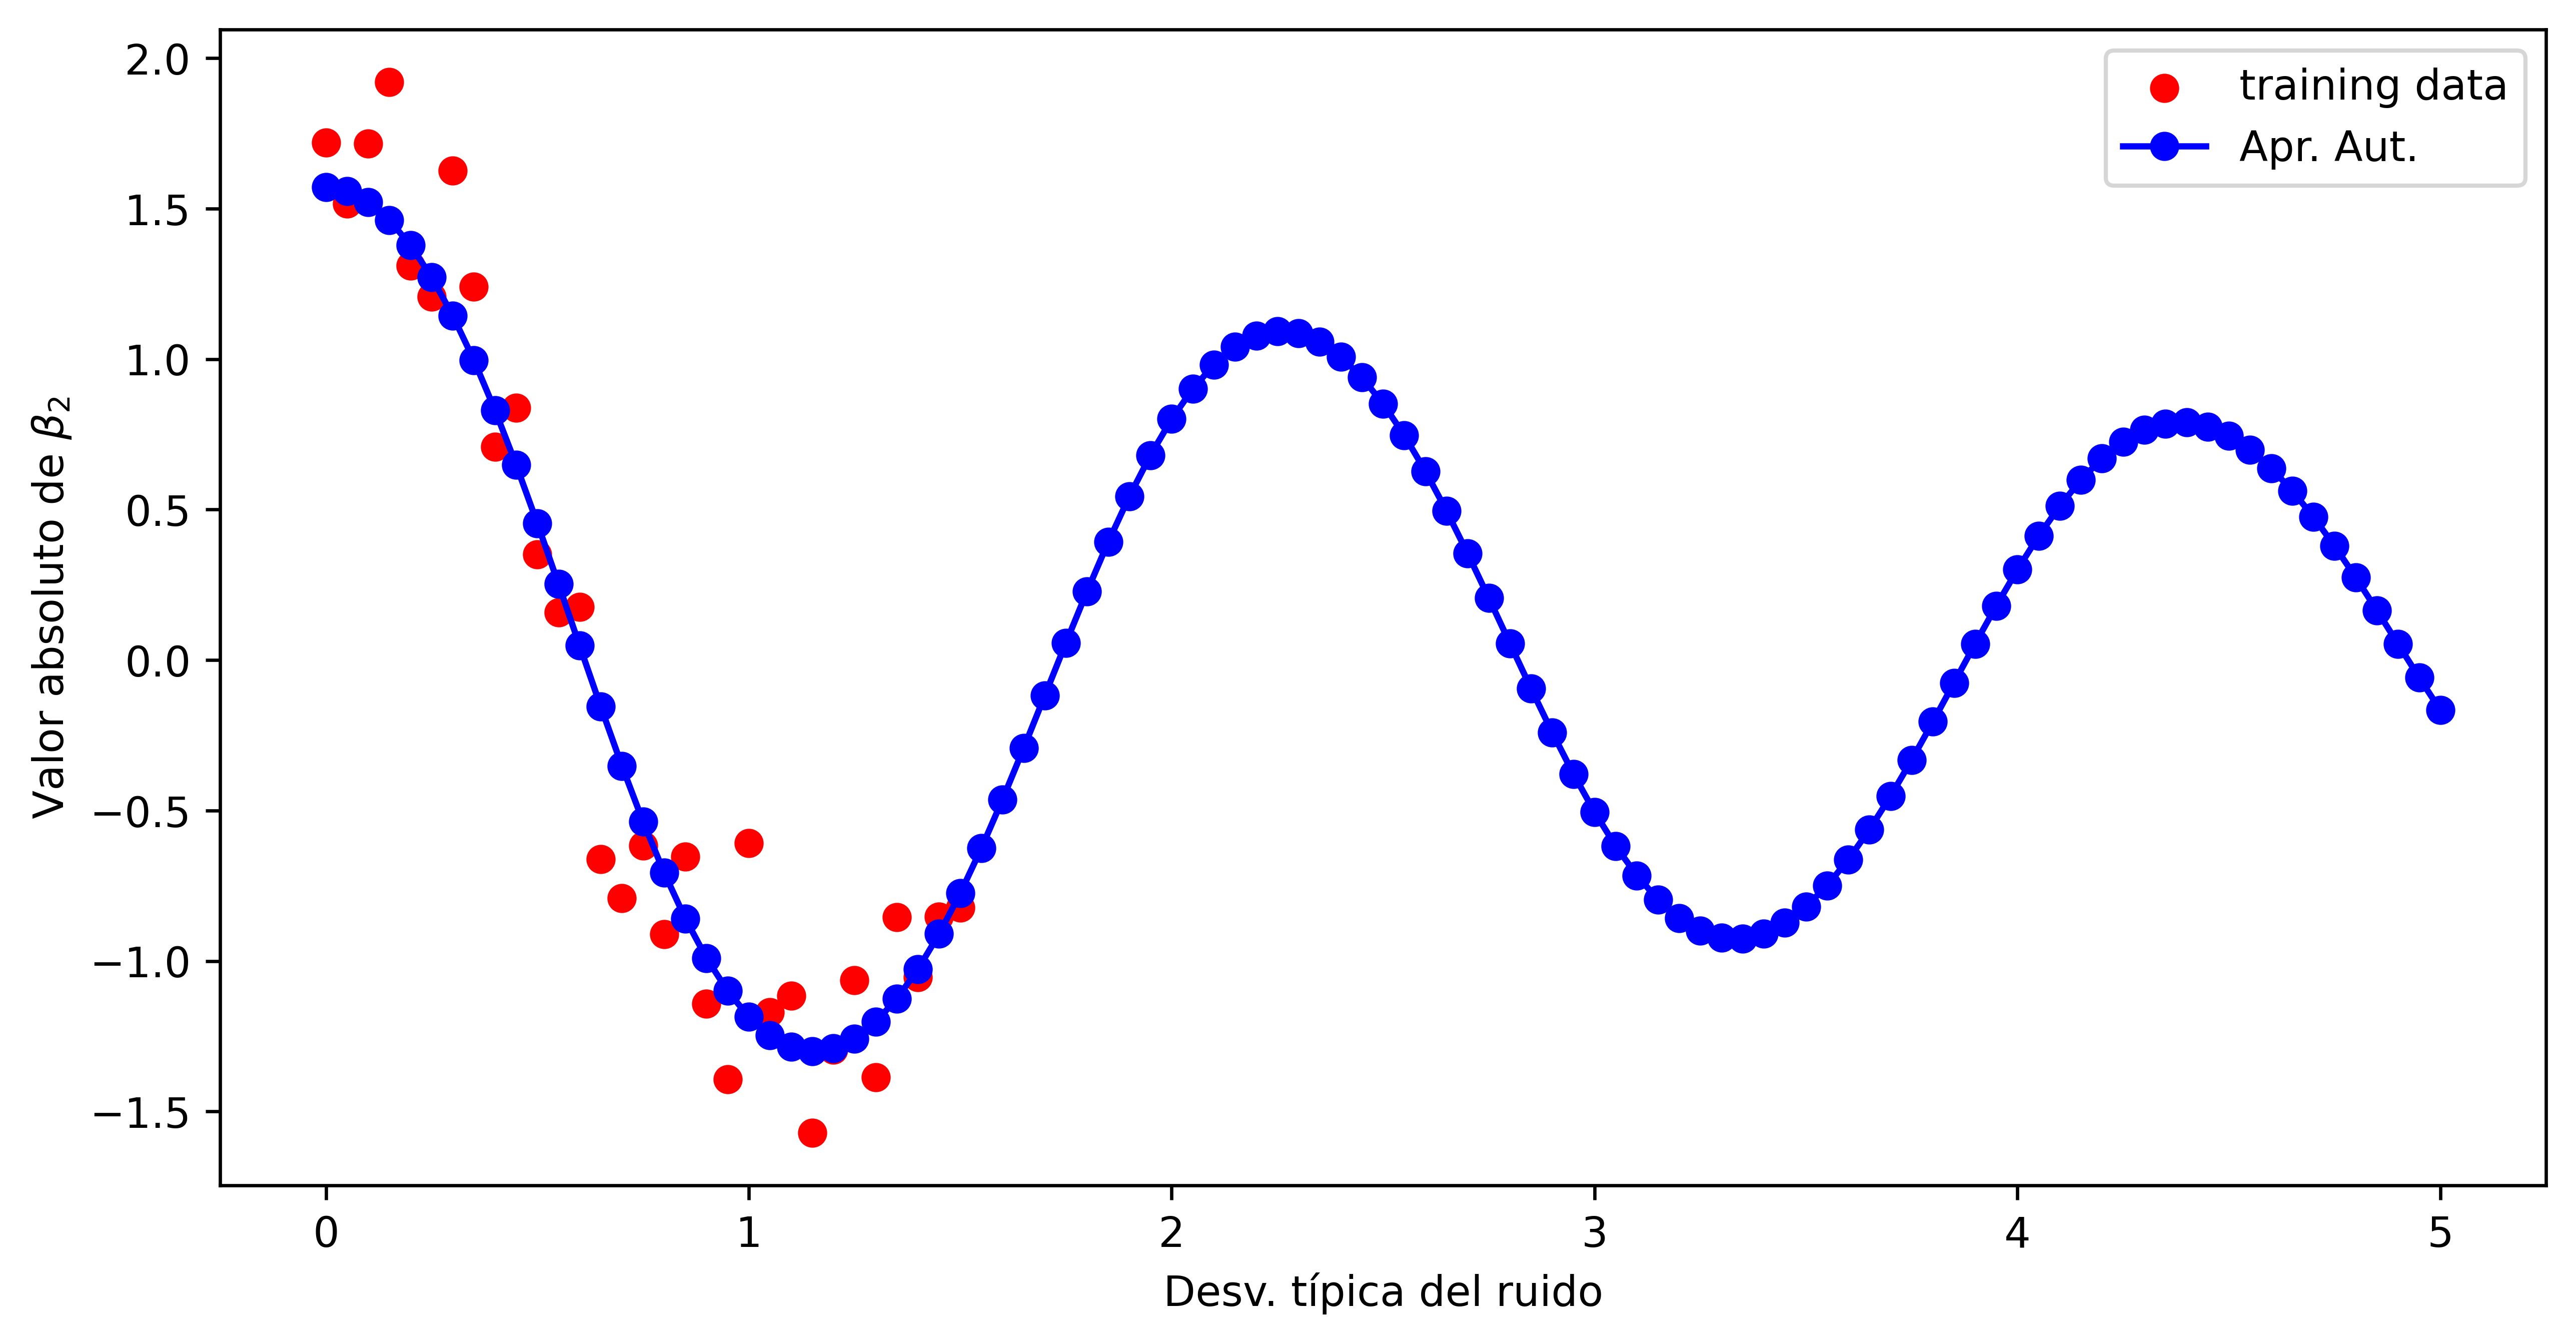

In [63]:
# Plot the results
plt.figure(figsize=(10, 5), dpi=600)
plt.scatter(t_train, actual_theta_noisy_train[:, 0], color='red', label='training data', marker='o')
plt.plot(t, estimated_theta[:, 0], color='blue', label='Apr. Aut.', marker='o')
plt.legend()
plt.xlabel('Desv. típica del ruido')
plt.ylabel(r'Valor absoluto de $\beta_2$')

plt.show()

In [8]:
beta_2_ml = []

noises = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for noise_sd in noises:
    # Actual theta values (assuming these are measured data)
    actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

    # Generate noise
    np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
    noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
    noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

    # Adding noise to the data
    actual_theta_noisy = np.copy(actual_theta)
    actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
    actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

    # Generate training dataset

    # Adjusting the time range
    t_max_new = 1.5  # Set the maximum time to 0.75 seconds
    t_train = np.arange(t_min, t_max_new + t_step, t_step)

    # Finding the index corresponding to the first second
    index_train = int(t_max_new / t_step) + 1

    # Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
    actual_theta_noisy_train = actual_theta_noisy[:index_train]

    # Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
    actual_theta_train = actual_theta[:index_train]

    # Initial parameters for gradient descent
    initial_bm = 0.1

    # Run gradient descent
    estimated_bm = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_bm)
    print("Estimated Parameters:", estimated_bm)

    beta_2_ml.append(estimated_bm)

beta_2_ml

Converged after 5095 iterations.
Estimated Parameters: 0.4999999997964112
Converged after 4456 iterations.
Estimated Parameters: 0.46159167069657997
Converged after 3965 iterations.
Estimated Parameters: 0.4246642636441885
Converged after 3690 iterations.
Estimated Parameters: 0.38916176126400326
Converged after 3881 iterations.
Estimated Parameters: 0.35502818058475155
Converged after 3622 iterations.
Estimated Parameters: 0.3222078517093454
Converged after 3381 iterations.
Estimated Parameters: 0.290645568973578


[0.4999999997964112,
 0.46159167069657997,
 0.4246642636441885,
 0.38916176126400326,
 0.35502818058475155,
 0.3222078517093454,
 0.290645568973578]

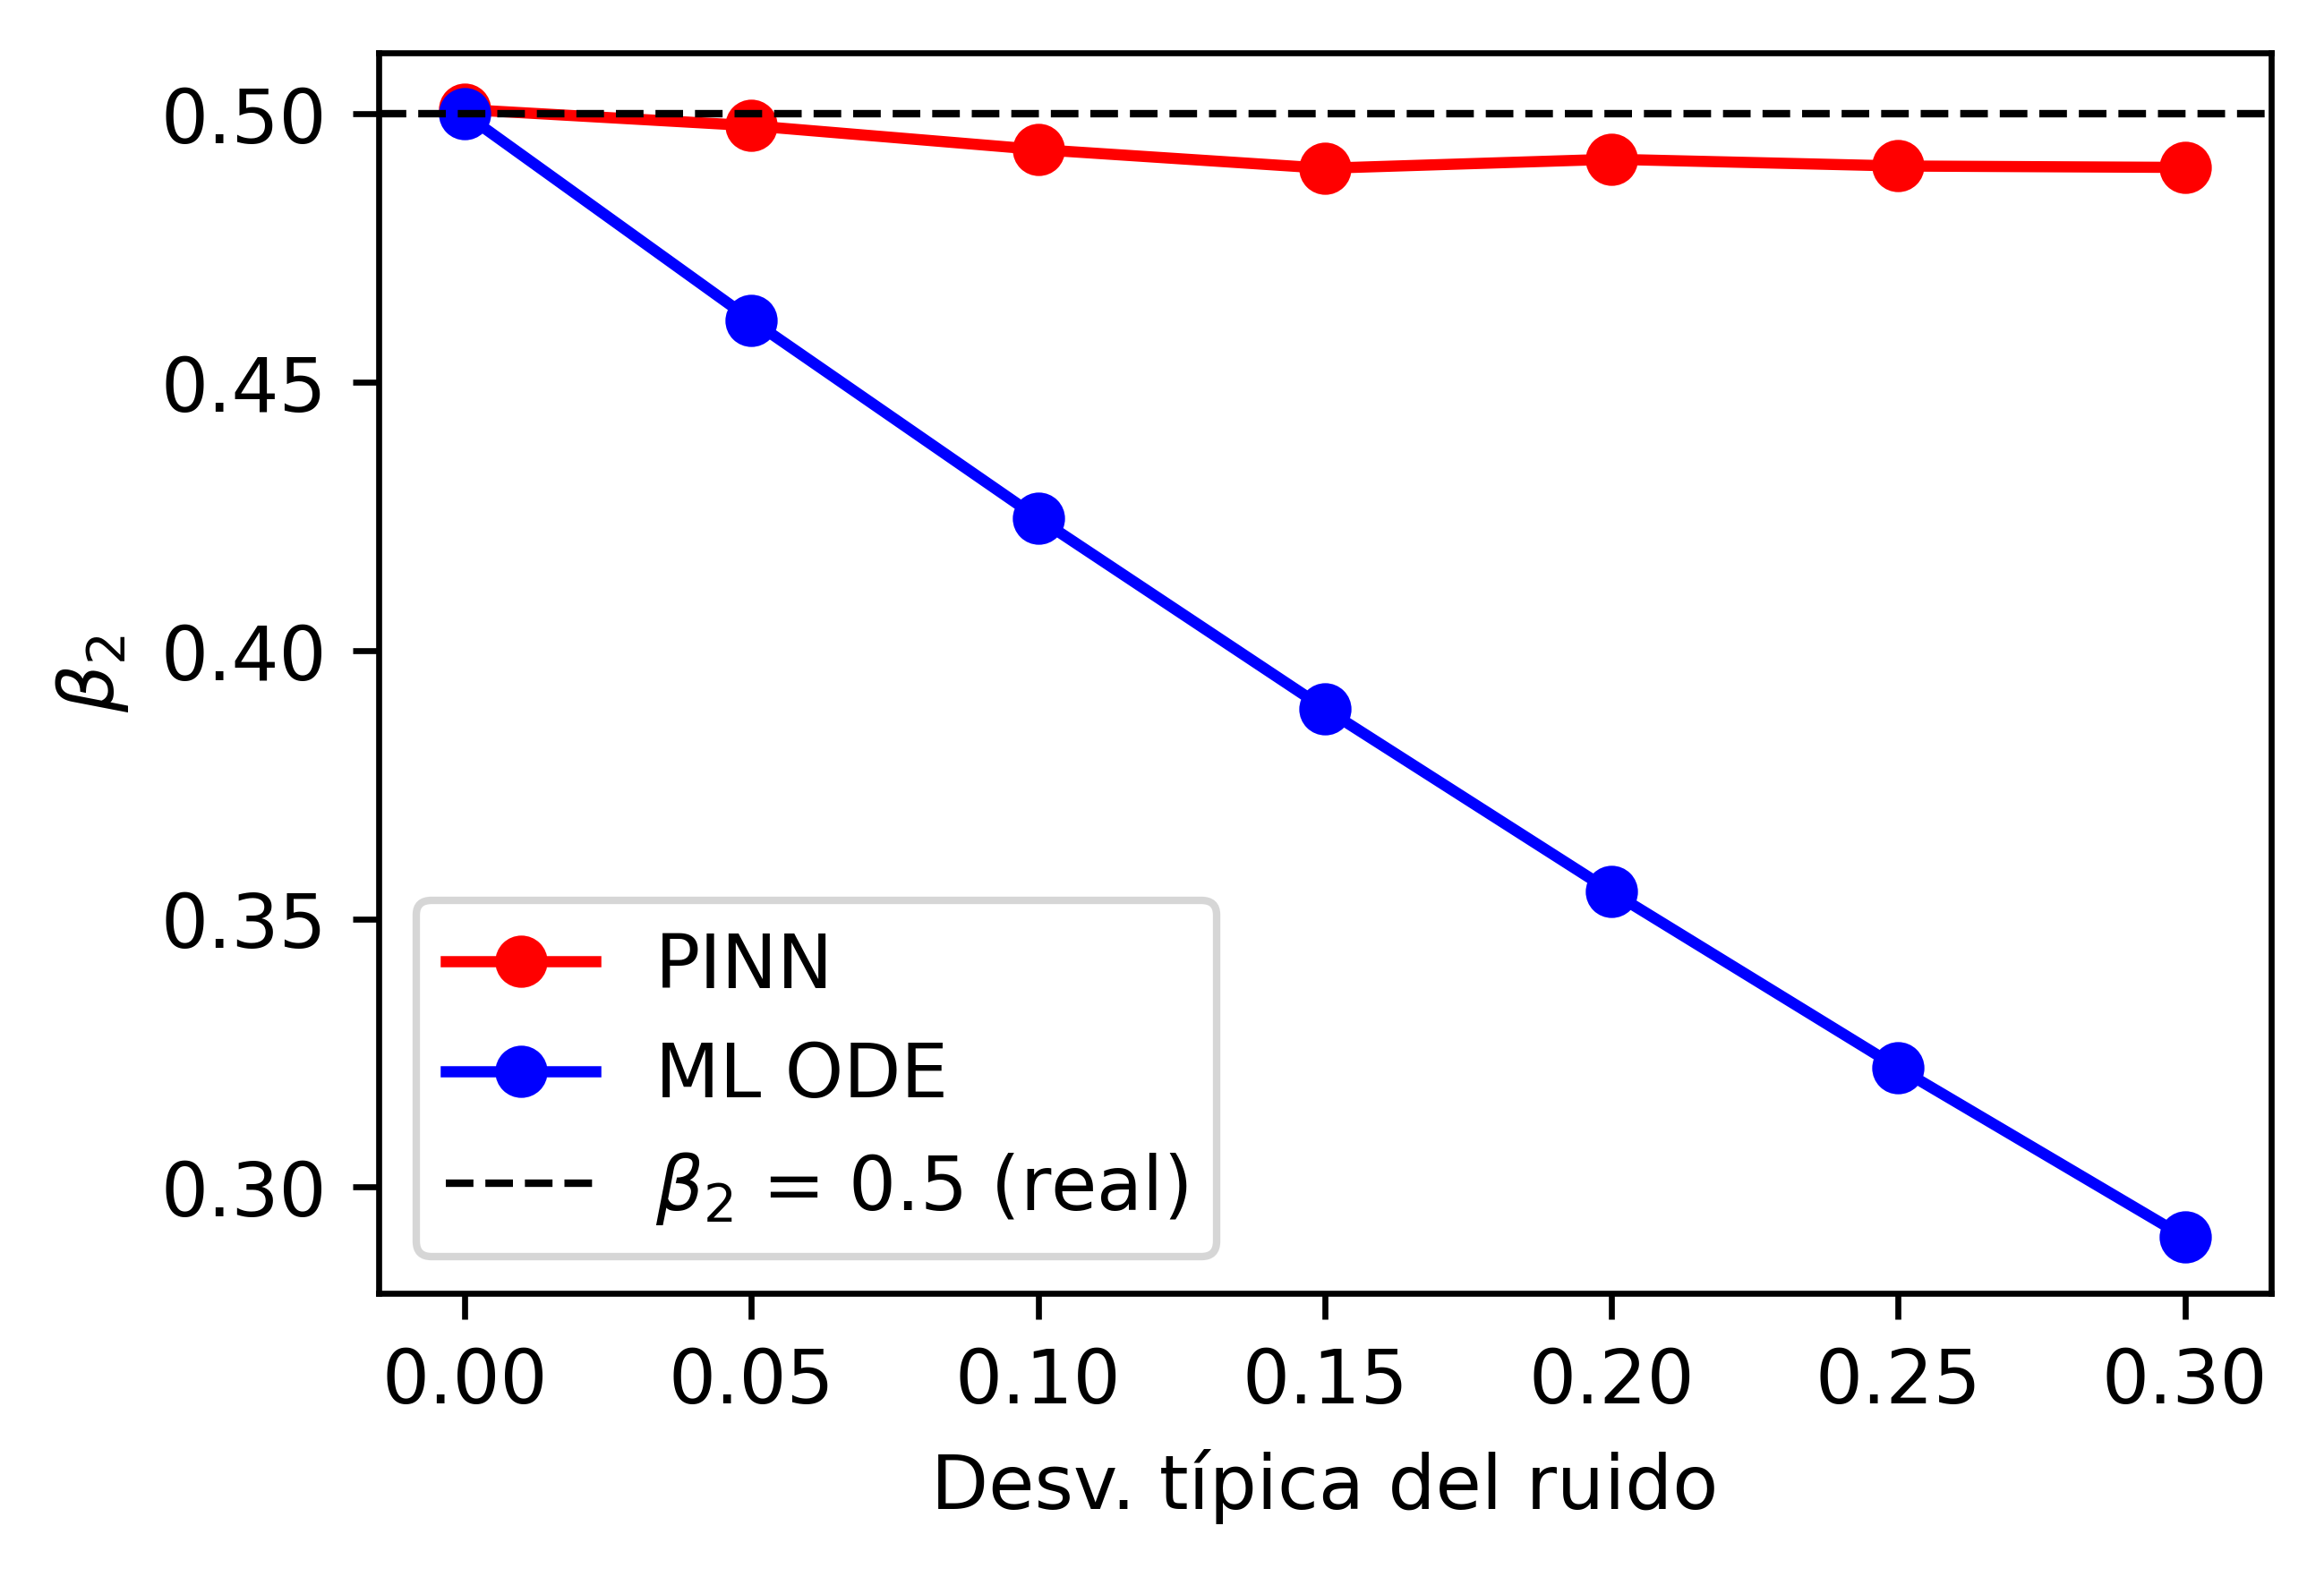

In [9]:
beta_2_pinn_abs = [abs(x) for x in beta_2_pinn]
beta_2_ml_abs = [abs(x) for x in beta_2_ml]

# Plot the results
plt.figure(figsize=(10, 3), dpi=600)
plt.subplot(1, 2, 1)
plt.plot(noises, beta_2_pinn_abs, color='red', label='PINN', marker='o')
plt.plot(noises, beta_2_ml_abs, color='blue', label='ML ODE', marker='o')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label=r'$\beta_2$ = 0.5 (real)')
plt.legend()
plt.xlabel('Desv. típica del ruido')
plt.ylabel(r'$\beta_2$')

plt.show()

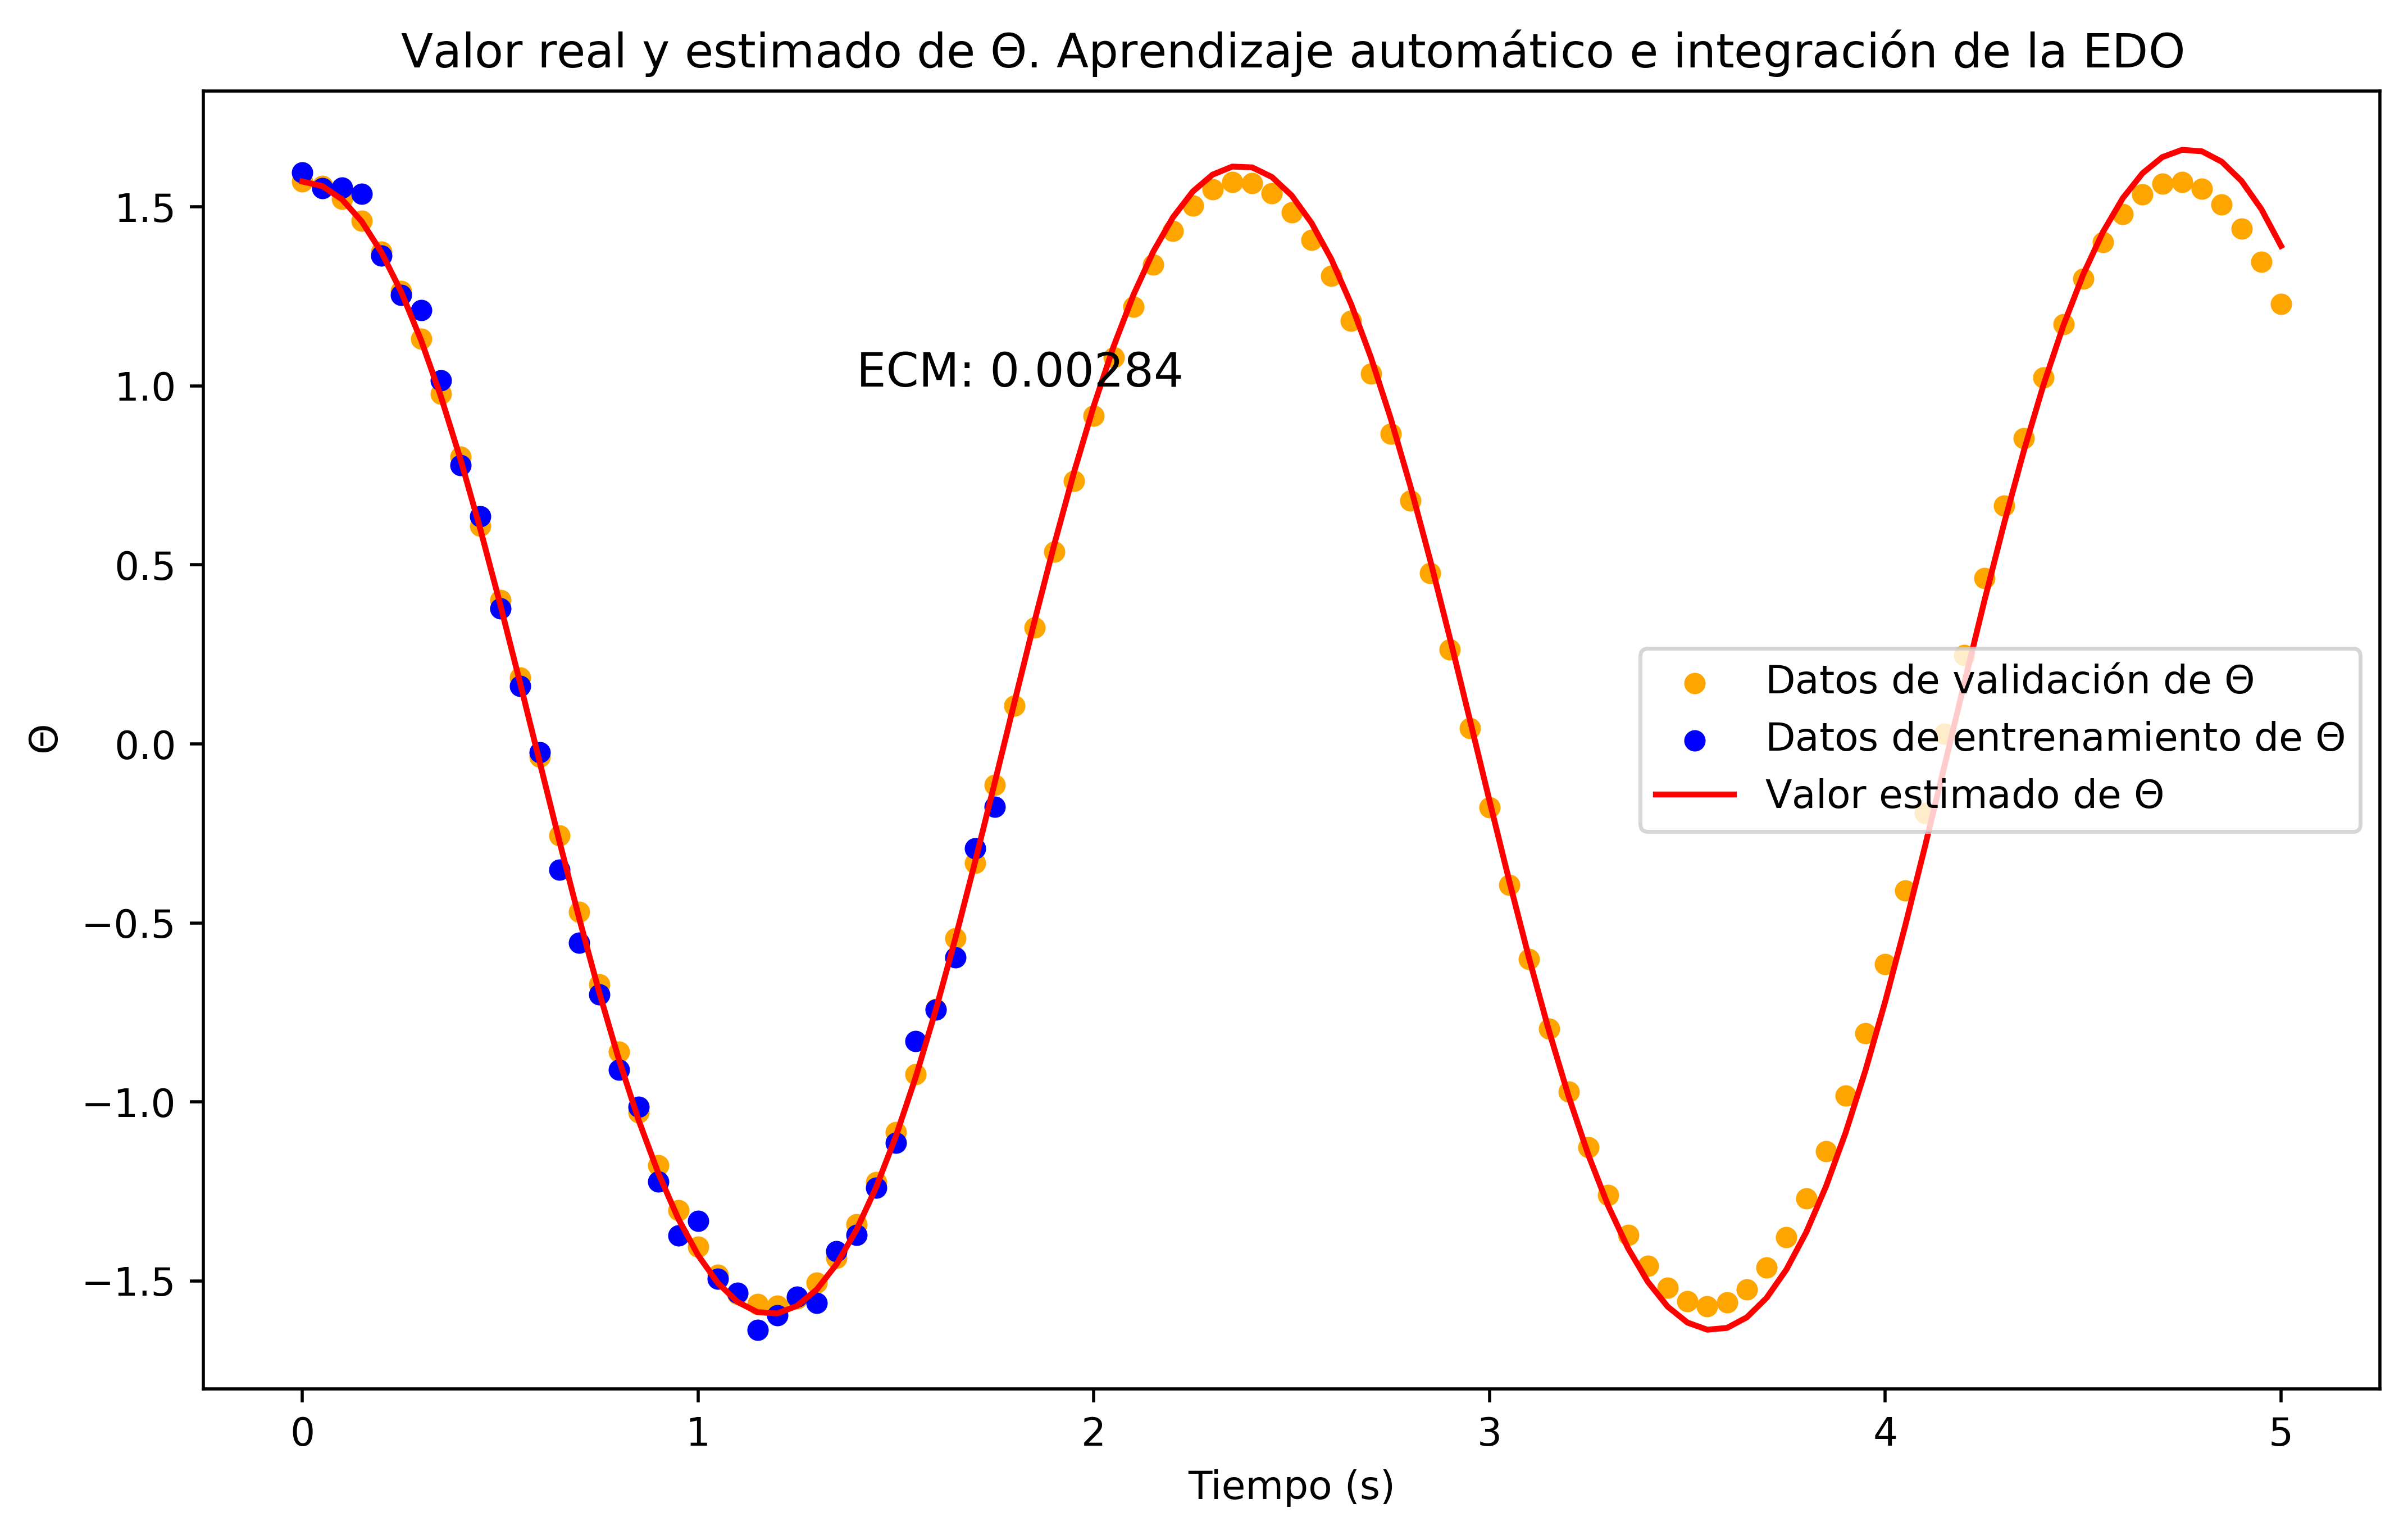

In [60]:
# Plotting
plt.figure(figsize=(10, 6), dpi = 500)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, estimated_theta[:, 0], label=r'Valor estimado de $\Theta$', color='red')

# Annotate plot with mean squared difference
plt.text(0.3, 0.8, f'ECM: {mean_squared_diff:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title(r'Valor real y estimado de $\Theta$. Aprendizaje automático e integración de la EDO')
plt.xlabel('Tiempo (s)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.grid(False)
plt.show()